In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, roc_curve,
    average_precision_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [30]:
df = pd.read_csv("/Users/prithvisiddharth/Desktop/Stroke/stroke-data.csv").replace('N/A', np.nan)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
df.drop('id', axis=1, inplace=True)

In [31]:
def handle_outliers(df, columns, method='clip'):
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns and df_clean[col].dtype in ['float64', 'int64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if method == 'clip':
                df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    return df_clean

In [32]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
df_clean = handle_outliers(df, numeric_cols, method='clip')

In [33]:

df_clean['age_glucose'] = df_clean['age'] * df_clean['avg_glucose_level']
df_clean['bmi_glucose'] = df_clean['bmi'] * df_clean['avg_glucose_level']
df_clean['age_bmi'] = df_clean['age'] * df_clean['bmi']
df_clean['glucose_bmi_ratio'] = df_clean['avg_glucose_level'] / (df_clean['bmi'] + 1)
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=[0, 30, 50, 70, 100], labels=['young', 'middle', 'senior', 'elderly'])
df_clean['bmi_category'] = pd.cut(df_clean['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])
df_clean['glucose_category'] = pd.cut(df_clean['avg_glucose_level'], bins=[0, 100, 125, 200, 1000], labels=['normal', 'prediabetic', 'diabetic', 'severe'])
df_clean['risk_score'] = (
    df_clean['age'] * 0.3 + 
    df_clean['avg_glucose_level'] * 0.2 + 
    df_clean['bmi'] * 0.1 +
    df_clean['hypertension'] * 0.2 +
    df_clean['heart_disease'] * 0.2
)
df_clean['age_risk'] = df_clean['age'] * df_clean['risk_score']
df_clean['glucose_risk'] = df_clean['avg_glucose_level'] * df_clean['risk_score']
df_clean['bmi_risk'] = df_clean['bmi'] * df_clean['risk_score']
df_clean['age_squared'] = df_clean['age'] ** 2
df_clean['glucose_squared'] = df_clean['avg_glucose_level'] ** 2
df_clean['bmi_squared'] = df_clean['bmi'] ** 2
df_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,age_bin,bmi_category,glucose_category,risk_score,age_risk,glucose_risk,bmi_risk,age_squared,glucose_squared,bmi_squared
0,Male,67.0,0,1,Yes,Private,Urban,169.3575,36.6,formerly smoked,...,senior,obese,diabetic,57.8315,3874.7105,9794.198261,2116.6329,4489.0,28681.962806,1339.56
1,Female,61.0,0,0,Yes,Self-employed,Rural,169.3575,NaN,never smoked,...,senior,NaN,diabetic,NaN,NaN,NaN,NaN,3721.0,28681.962806,NaN
2,Male,80.0,0,1,Yes,Private,Rural,105.9200,32.5,never smoked,...,elderly,obese,prediabetic,48.6340,3890.7200,5151.313280,1580.6050,6400.0,11219.046400,1056.25
3,Female,49.0,0,0,Yes,Private,Urban,169.3575,34.4,smokes,...,middle,obese,diabetic,52.0115,2548.5635,8808.537611,1789.1956,2401.0,28681.962806,1183.36
4,Female,79.0,1,0,Yes,Self-employed,Rural,169.3575,24.0,never smoked,...,elderly,normal,diabetic,60.1715,4753.5485,10190.494811,1444.1160,6241.0,28681.962806,576.00


In [34]:
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
num_features = ['age', 'avg_glucose_level', 'bmi', 'age_glucose', 'bmi_glucose', 'age_bmi', 
                'glucose_bmi_ratio', 'risk_score', 'age_risk', 'glucose_risk', 'bmi_risk',
                'age_squared', 'glucose_squared', 'bmi_squared']
cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 
                'Residence_type', 'smoking_status', 'age_bin', 'bmi_category', 'glucose_category']
class_weight = y.value_counts()[0] / y.value_counts()[1]

In [35]:
num_pipeline_robust = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline_robust, num_features),
    ('cat', cat_pipeline, cat_features)
])
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resample', SMOTE(random_state=42, k_neighbors=3)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])
best_pipeline.fit(X_train, y_train)
y_probs = best_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_probs >= optimal_threshold).astype(int)
report = classification_report(y_test, y_pred, output_dict=True)

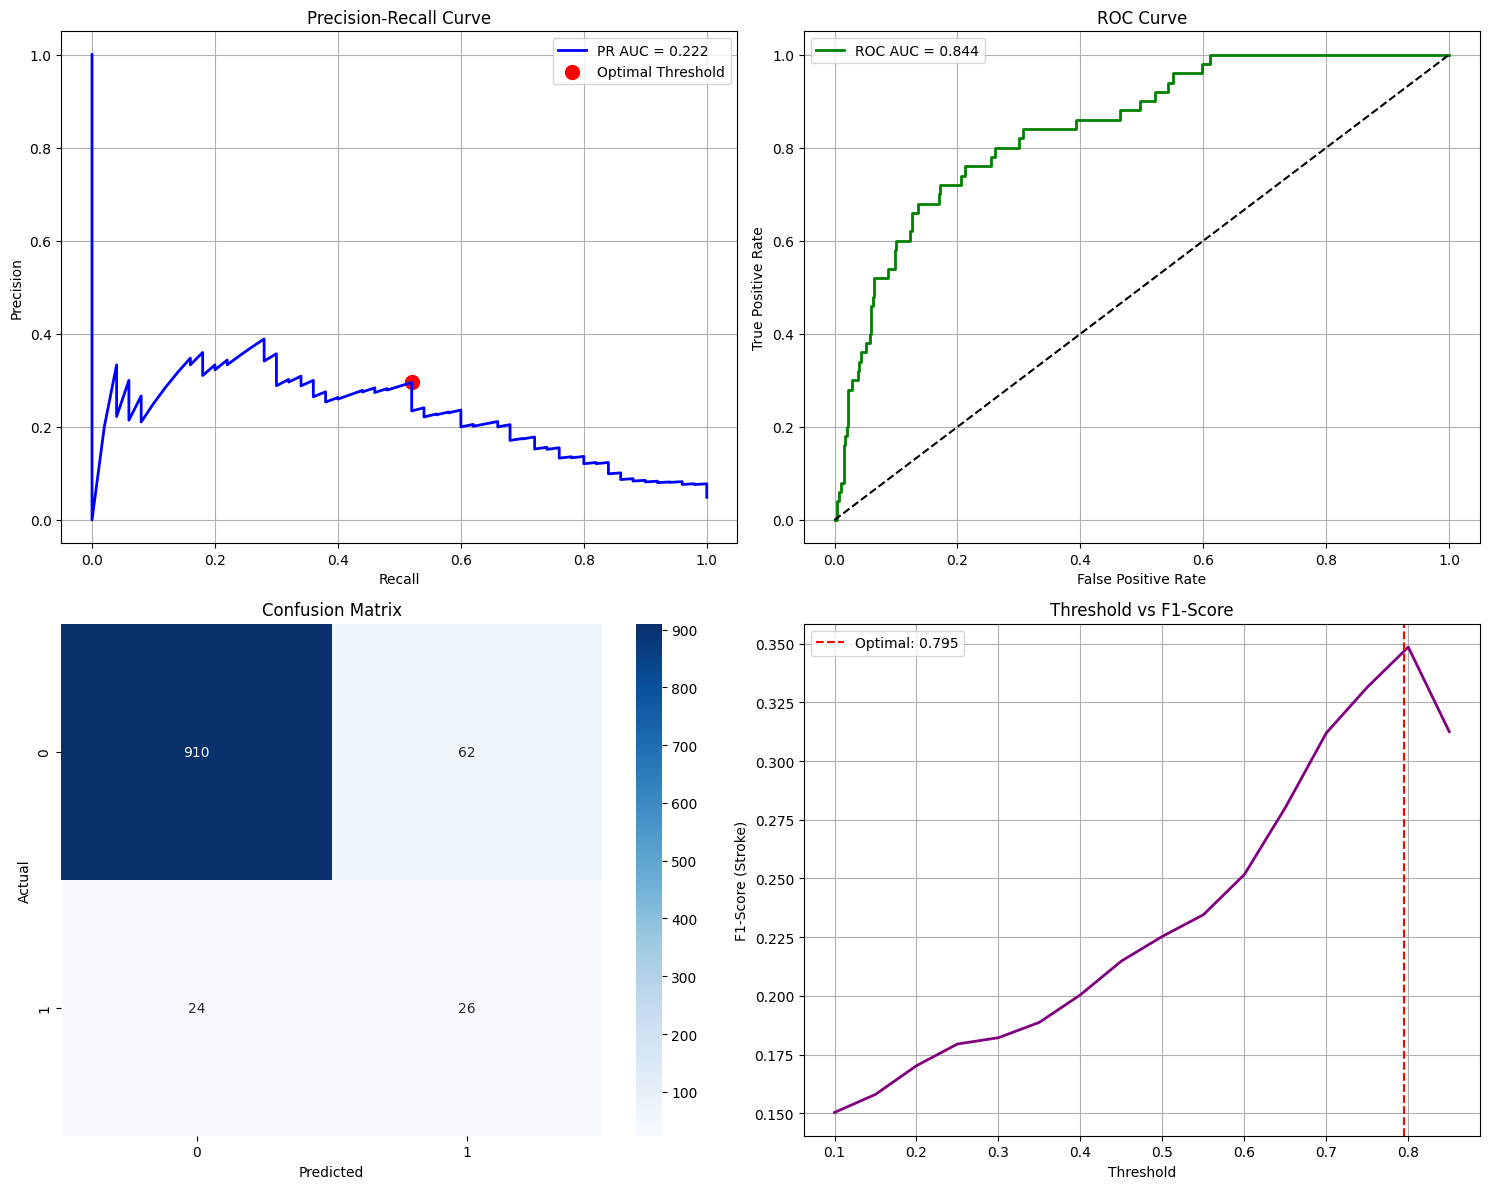

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
axes[0, 0].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}', linewidth=2, color='blue')
axes[0, 0].scatter(recall[np.argmax(2 * precision * recall / (precision + recall + 1e-10))], 
                    precision[np.argmax(2 * precision * recall / (precision + recall + 1e-10))], 
                    color='red', s=100, label='Optimal Threshold')
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision-Recall Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
axes[0, 1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', linewidth=2, color='green')
axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True)
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
# Threshold Analysis
f1_scores = []
thresholds_range = np.arange(0.1, 0.9, 0.05)
for threshold in thresholds_range:
    y_pred_temp = (y_probs >= threshold).astype(int)
    report_temp = classification_report(y_test, y_pred_temp, output_dict=True)
    f1_scores.append(report_temp['1']['f1-score'])
axes[1, 1].plot(thresholds_range, f1_scores, linewidth=2, color='purple')
axes[1, 1].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1-Score (Stroke)')
axes[1, 1].set_title('Threshold vs F1-Score')
axes[1, 1].legend()
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()